In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.tri as tri
import matplotlib.gridspec as gridspec
#from matplotlib.backends.backend_pdf import PdfPages

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points
from src.transpositions import Transposition

from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

# Defining Transposition Functions

## Catch the Difference betweeen Depth Posets

In [3]:
def depth_posets_are_different(dp0: DepthPoset, dp1: DepthPoset) -> bool:
    # 
    nodes0 = set([node.source for node in dp0.nodes])
    nodes1 = set([node.source for node in dp1.nodes])
    if nodes0 != nodes1:
        return True
    edges0 = set([(node0.source, node1.source) for node0, node1 in dp0.edges])
    edges1 = set([(node0.source, node1.source) for node0, node1 in dp1.edges])
    if edges0 != edges1:
        return True
    return False

# Full Random Model

In this model we define the simplicial complex by the Delauney triangulation of $n$ points uniformly distributed in $[0, 1]^d$ ($d = 2$).

After this we define a random filtration for each simplex:
$$
    f(s) \sim U[\dim{s}, \dim{s} + 1]
$$

## Generate a Delauney Complex and 2 Filtrations on this

/tmp/ipykernel_99818/933326602.py:23: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])
/tmp/ipykernel_99818/933326602.py:23: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])


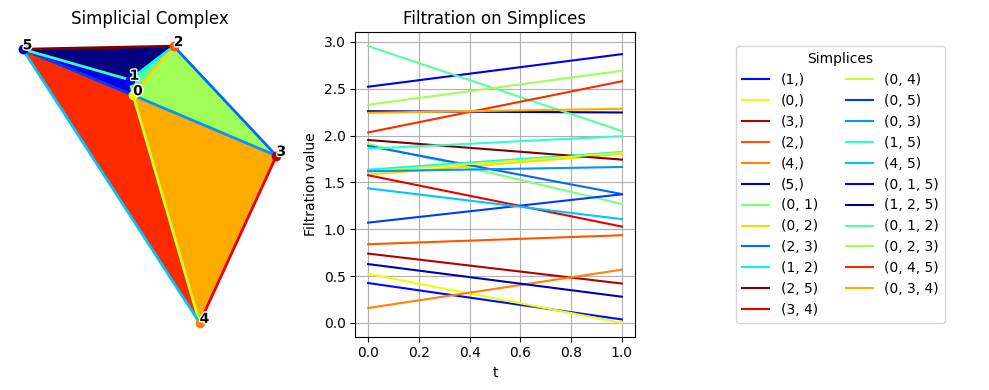

In [4]:
n = 6
complex_dimension = 2
points = np.random.random([n, complex_dimension])

simplices = np.array([tuple(s) for s, _ in gh.AlphaComplex(points).create_simplex_tree().get_simplices()], dtype=object)
simplices = simplices[np.argsort([len(s) for s in simplices])]
dims = np.vectorize(len)(simplices) - 1

filtration0 = np.random.random(len(simplices)) + dims
filtration1 = np.random.random(len(simplices)) + dims

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

colors = np.linspace(0, 1, len(simplices))
colors = np.random.choice(colors, len(colors), replace=False)
colors = plt.get_cmap('jet')(colors)
lines = []
labels = []

for i in range(len(simplices)):
    plot_simplex(list(simplices[i]), points, color=colors[i], ax=axs[0])
    
    line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])
    lines.append(line)
    labels.append(str(simplices[i]))

axs[0].set_title('Simplicial Complex')
axs[0].axis('off')
enumerate_points(points, ax=axs[0], weight='semibold', forewidth=2)

axs[1].set_title('Filtration on Simplices')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Filtration value')
axs[1].grid(True)

axs[2].axis('off')
axs[2].legend(lines, labels, loc='center', title="Simplices", ncol=np.ceil(len(simplices)/18))

plt.tight_layout()
plt.show()

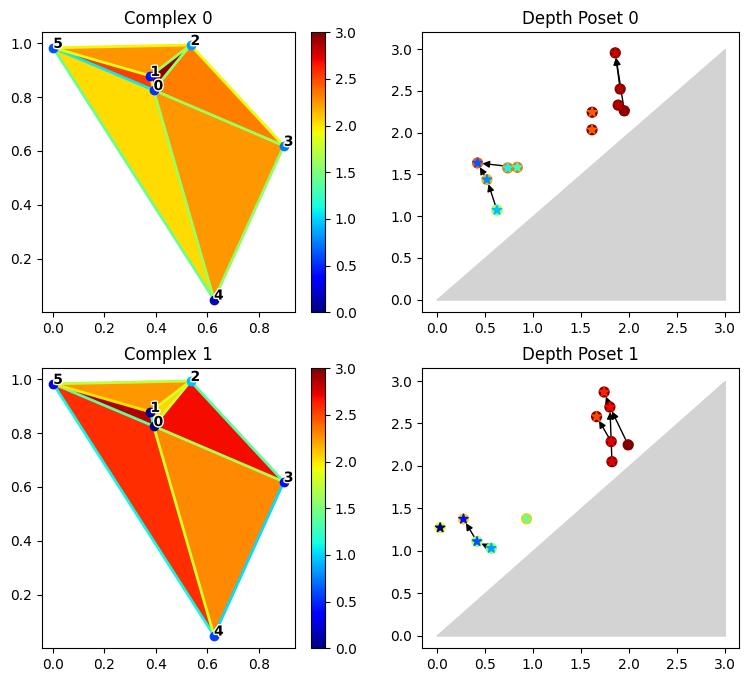

In [5]:
stree0 = gh.SimplexTree()
for simplex, value in zip(simplices, filtration0):
    stree0.insert(simplex, value)
dp0 = DepthPoset.from_simplex_tree(stree0)

stree1 = gh.SimplexTree()
for simplex, value in zip(simplices, filtration1):
    stree1.insert(simplex, value)
dp1 = DepthPoset.from_simplex_tree(stree1)

cmap = plt.get_cmap('jet')
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
for i, (streei, dpi) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Complex {i}')
    sm = plot_filtred_complex2d(streei, points, ax=axs[i, 0], cmap=cmap, vmin=0, vmax=complex_dimension+1)
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0], weight='semibold', forewidth=2)
    
    birth_colors = [cmap(streei.filtration(node.source[0])/complex_dimension) for node in dpi.nodes]
    death_colors = [cmap(streei.filtration(node.source[1])/complex_dimension) for node in dpi.nodes]

    axs[i, 1].set_title(f'Depth Poset {i}')
    nx.draw_networkx_edges(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, hide_ticks=False)
    nx.draw_networkx_nodes(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, node_shape='o', node_color=death_colors, hide_ticks=False)
    nx.draw_networkx_nodes(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, node_shape='*', node_color=birth_colors, hide_ticks=False)
    
    axs[i, 1].fill_between([0, complex_dimension + 1], [0, 0], [0, complex_dimension + 1], color='lightgrey')

In [6]:
depth_posets_are_different(dp0, dp1), dp0 != dp1

(True, True)

In [7]:
dp0.nodes[0], dp1.nodes[0]

(ShallowPair([1.9536, 2.2610], source=((2, 5), (1, 2, 5)), dim=1),
 ShallowPair([1.9942, 2.2472], source=((1, 5), (1, 2, 5)), dim=1))

## Define the Transposition Moments

In [8]:
def get_cross_parameters(y0, y1, t0=0, t1=1, filter_outside=True):
    """
    Returns the matrix of cross parameters between two arrays.

    Parameters:
        y0, y1: two arrays of the same length
        t0, t1: the time points for the arrays
        filter_outside: if True, filter out the values outside the range [t0, t1]

    Returns:
        cross_parameters: the matrix of cross parameters
    """
    y0 = np.asarray(y0)
    y1 = np.asarray(y1)
    if y0.shape != y1.shape:
        raise ValueError("Arrays must have the same length.")
    if y0.ndim != 1:
        raise ValueError("Arrays must be 1D.")
    
    yi0 = y0.reshape(-1, 1)
    yi1 = y1.reshape(-1, 1)
    yj0 = y0.reshape(1, -1)
    yj1 = y1.reshape(1, -1)

    cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


    if filter_outside:
        cross_parameters[cross_parameters < min(t0, t1)] = np.nan
        cross_parameters[cross_parameters > max(t0, t1)] = np.nan
    return cross_parameters

In [9]:
cross_parameters = [get_cross_parameters(filtration0[dims == i], filtration1[dims == i]) for i in range(complex_dimension + 1)]

eps = 0.8*min([min(np.unique(np.triu(i))[1:-1] - np.unique(np.triu(i))[:-2]) for i in cross_parameters])


/tmp/ipykernel_99818/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


In [10]:


df_transpositions = []
for dim, cross_parameters_dim in enumerate(cross_parameters):
    for i0, i1 in np.argwhere(~np.isnan(cross_parameters_dim) & np.triu(np.ones(cross_parameters_dim.shape, dtype=bool))):
        # define time and filtration value
        time = cross_parameters_dim[i0, i1]
        filtration_value = filtration0[dims == dim][i0]*(1 - time) + filtration1[dims == dim][i0]*time

        # define simplices
        simplex0 = simplices[dims == dim][i0]
        simplex1 = simplices[dims == dim][i1]

        # define the complex and the depth poset before the transposition
        time_before = time - eps
        filtration_before = filtration0*(1 - time_before) + filtration1*time_before
        stree_before = gh.SimplexTree()
        for simplex, value in zip(simplices, filtration_before):
            stree_before.insert(simplex, value)
        dp_before = DepthPoset.from_simplex_tree(stree_before)

        # define the complex and the depth poset after the transposition
        time_after = time + eps
        filtration_after = filtration0*(1 - time_after) + filtration1*time_after
        stree_after = gh.SimplexTree()
        for simplex, value in zip(simplices, filtration_after):
            stree_after.insert(simplex, value)
        dp_after = DepthPoset.from_simplex_tree(stree_after)

        # initialize transposition
        df_transpositions.append(
            {   
                'time': time,
                'value': filtration_value, 
                'stree before': stree_before.copy(), 
                'stree after': stree_after.copy(), 
                'transposition object': Transposition.from_simplex_tree(stree_before, simplex0, simplex1), 
                'changing': dp_before != dp_after, 
            }
        )

for i in range(len(df_transpositions)):
    df_transpositions[i].update(df_transpositions[i]['transposition object'].to_dict())
    if df_transpositions[i]['type'] in ['birth-birth', 'death-death', 'birth-death']:
        df_transpositions[i].update({'delta': df_transpositions[i]['transposition object'].get_classifying_matrix(reduce_matrix=True)})



df_transpositions = pd.DataFrame(df_transpositions)
df_transpositions = df_transpositions.sort_values('time')

df_transpositions.loc[(df_transpositions['switch'] == 'switch forward') | (df_transpositions['switch'] == 'switch backward'), 'switch'] = 'switch'

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

self.index1 - self.index0 != 1
self.index1 - self.index0 != 1
df_transpositions.shape = (34, 14)


,time,value,stree before,stree after,transposition object,changing,index 0,index 1,cell 0,cell 1,dim,type,switch,delta
24,0.013224,1.620170,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(0, 4), (0, 3)>",True,10,11,"(0, 4)","(0, 3)",1,birth-birth,no switch,"((1, 1), (0, 1))"
18,0.046615,1.866046,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(1, 5), (2, 3)>",False,13,14,"(1, 5)","(2, 3)",1,birth-birth,no switch,"((0, 1), (1, 0))"
11,0.065729,1.868615,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(1, 5), (0, 1)>",True,14,15,"(1, 5)","(0, 1)",1,birth-birth,switch,"((1, 0), (1, 1))"
6,0.163946,1.805780,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(2, 3), (0, 1)>",False,13,14,"(2, 3)","(0, 1)",1,birth-birth,no switch,"((1, 0), (0, 1))"
14,0.204314,1.628896,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(0, 2), (0, 3)>",False,9,10,"(0, 2)","(0, 3)",1,birth-death,no switch,"((0, 1, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0,..."


In [11]:
df_transpositions[['changing', 'type', 'switch']].value_counts(dropna=False).reset_index().pivot_table(index=['type', 'switch'], columns='changing', values='count').fillna(0).astype(int)

changing                  False  True 
type           switch                 
birth-birth    no switch      5      3
               switch         0      5
birth-death    no switch      4      0
               switch         0      2
birth-unpaired undefined      0      2
death-death    no switch      5      6
               switch         0      2

In [12]:
df_transpositions[['changing', 'type', 'switch', 'delta']].value_counts(dropna=False).reset_index().pivot_table(index=['type', 'switch', 'delta'], columns='changing', values='count').fillna(0).astype(int)

changing                                                                  False  \
type        switch    delta                                                       
birth-birth no switch ((0, 1), (1, 0))                                        2   
                      ((1, 0), (0, 1))                                        3   
                      ((1, 1), (0, 1))                                        0   
            switch    ((1, 0), (1, 1))                                        0   
                      ((1, 1), (1, 0))                                        0   
birth-death no switch ((0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, ...      3   
                      ((0, 1, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0, ...      1   
            switch    ((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0, ...      0   
death-death no switch ((0, 1), (1, 0))                                        1   
                      ((1, 0), (0, 1))                                        4   
                      ((1, 1), (0, 1))                                        0   
                      ((1, 1), (1, 0))                                        0   
            switch    ((0, 1), (1, 1))                                        0   

changing                                                                  True   
type        switch    delta                                                      
birth-birth no switch ((0, 1), (1, 0))                                        0  
                      ((1, 0), (0, 1))                                        0  
                      ((1, 1), (0, 1))                                        3  
            switch    ((1, 0), (1, 1))                                        3  
                      ((1, 1), (1, 0))                                        2  
birth-death no switch ((0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, ...      0  
                      ((0, 1, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0, ...      0  
            switch    ((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0, ...      2  
death-death no switch ((0, 1), (1, 0))                                        0  
                      ((1, 0), (0, 1))                                        0  
                      ((1, 1), (0, 1))                                        3  
                      ((1, 1), (1, 0))                                        3  
            switch    ((0, 1), (1, 1))                                        2

## Plot the switch and not swithc transpositions

In [13]:
def get_plot_category(row):
    if row['switch'] == 'switch':
        return f'switch {row['type']}'
    else:
        return 'no switch'

df_transpositions['plot category'] = df_transpositions.apply(get_plot_category, axis=1)


print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (34, 15)


,time,value,stree before,stree after,transposition object,changing,index 0,index 1,cell 0,cell 1,dim,type,switch,delta,plot category
24,0.013224,1.620170,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(0, 4), (0, 3)>",True,10,11,"(0, 4)","(0, 3)",1,birth-birth,no switch,"((1, 1), (0, 1))",no switch
18,0.046615,1.866046,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(1, 5), (2, 3)>",False,13,14,"(1, 5)","(2, 3)",1,birth-birth,no switch,"((0, 1), (1, 0))",no switch
11,0.065729,1.868615,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(1, 5), (0, 1)>",True,14,15,"(1, 5)","(0, 1)",1,birth-birth,switch,"((1, 0), (1, 1))",switch birth-birth
6,0.163946,1.805780,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(2, 3), (0, 1)>",False,13,14,"(2, 3)","(0, 1)",1,birth-birth,no switch,"((1, 0), (0, 1))",no switch
14,0.204314,1.628896,<gudhi.simplex_tree.SimplexTree object at 0x78...,<gudhi.simplex_tree.SimplexTree object at 0x78...,"<(0, 2), (0, 3)>",False,9,10,"(0, 2)","(0, 3)",1,birth-death,no switch,"((0, 1, 0, 0), (0, 0, 0, 0), (0, 0, 0, 1), (0,...",no switch


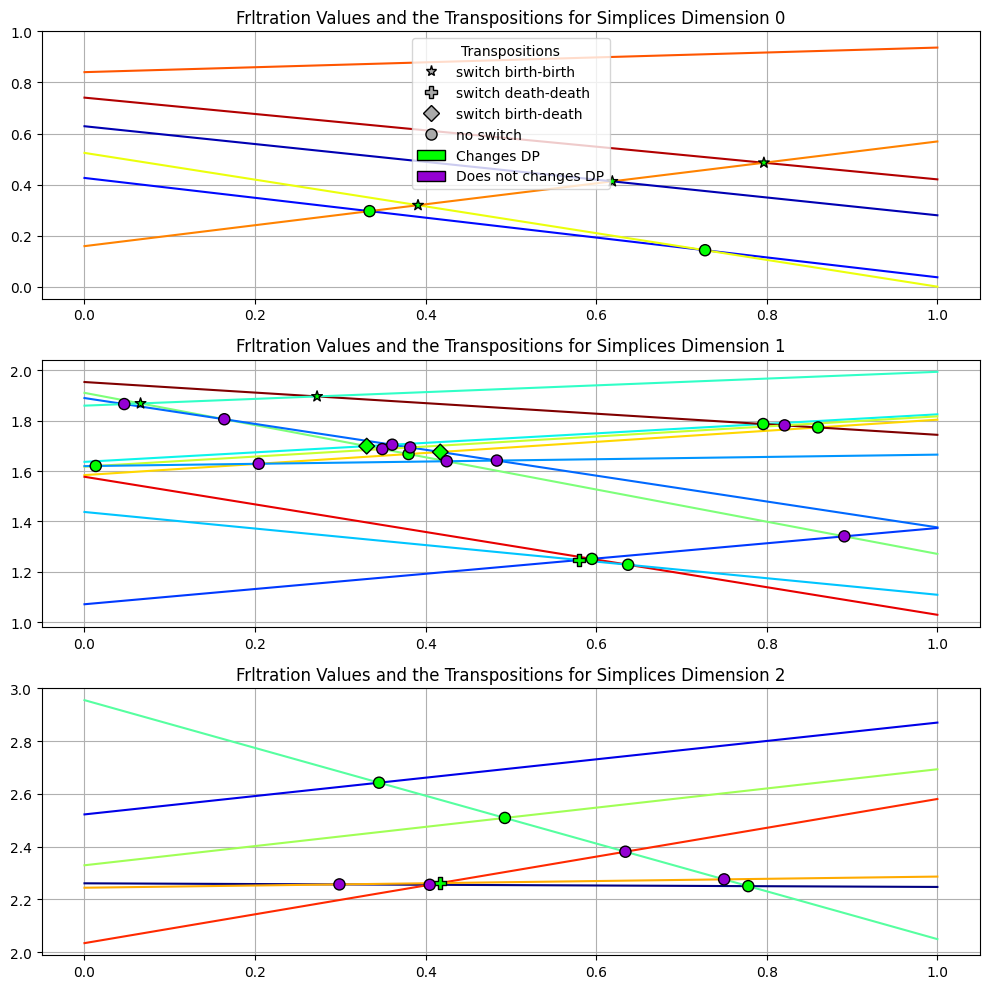

In [14]:
plot_category_markers = {
    'switch birth-birth': '*', 
    'switch death-death': 'P', 
    'switch birth-death': 'D', 
    'no switch': 'o',
}

changing_colors = {
    True: 'lime', 
    False: 'darkviolet'
}



fig, axs = plt.subplots(3, figsize=[10, 10])

for dim in range(3):
    axs[dim].set_title(f'Frltration Values and the Transpositions for Simplices Dimension {dim}')
    for simplex, y0, y1, color in zip(simplices[dims == dim], filtration0[dims == dim], filtration1[dims == dim], colors[dims == dim]):
        axs[dim].plot([0, 1], [y0, y1], color=color)
    
    for category, marker in plot_category_markers.items():
        dfi = df_transpositions[(df_transpositions['dim'] == dim) & (df_transpositions['plot category'] == category)]
        x = dfi['time']
        y = dfi['value']
        point_colors = dfi['changing'].replace(changing_colors)
        
        axs[dim].scatter(x, y, marker=marker, color=point_colors, edgecolor='black', s=64, zorder=2, linewidth=1)
    
    axs[dim].set_yticks(np.linspace(dim, dim + 1, 6))
    axs[dim].grid(True)


custom_lines = [
    Line2D([], [], color='none', marker=marker, markerfacecolor='darkgrey', markeredgecolor='black',
           markersize=8, label=category) for category, marker in plot_category_markers.items()
] + [
    Patch(facecolor=changing_colors[True], edgecolor='black',label='Changes DP'), 
    Patch(facecolor=changing_colors[False], edgecolor='black',label='Does not changes DP'), 
]
axs[0].legend(handles=custom_lines, title='Transpositions')

plt.tight_layout()
plt.show()

# Height Model
In this model we define the simplicial complex by the Delauney triangulation of $n$ points uniformly distributed in $[0, 1]^d$ ($d = 2$).

After this we define the uniformly distributed in $[0, 1]$ height for each vertex. Then the filtration value of the simplex will be the maximum haight of its vertices.

## Generate a Complex and 2 Height Vectors

In [15]:
def get_heights_stree(heights, triangles) -> gh.SimplexTree:
    # returns the SimplexTree coresponding the given heights vector and the triangulation
    heights = np.asarray(heights)
    stree = gh.SimplexTree()
    for triangle in triangles:
        for i in range(1, len(triangle) + 1):
            for simplex in itertools.combinations(triangle, r=i):
                value = max(heights[list(simplex)])
                stree.insert(simplex, value)
    return stree

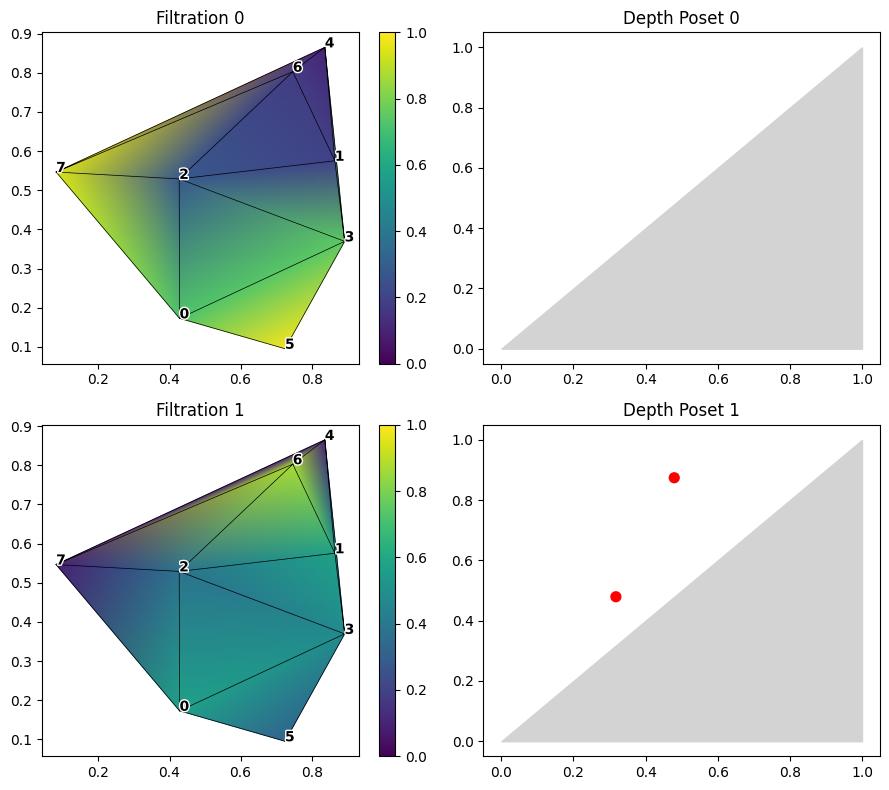

In [16]:
n = 8
complex_dimension = 2
points = np.random.random([n, complex_dimension])

simplices = np.array([tuple(s) for s, _ in gh.AlphaComplex(points).create_simplex_tree().get_simplices()], dtype=object)
simplices = simplices[np.argsort([len(s) for s in simplices])]
dims = np.vectorize(len)(simplices) - 1

triangles = simplices[dims == 2]

heights0 = np.random.random(n)
heights1 = np.random.random(n)

stree0 = get_heights_stree(heights0, triangles)
stree1 = get_heights_stree(heights1, triangles)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

intersecting_node_sources = {node.source for node in dp0.nodes} & {node.source for node in dp1.nodes}
intersecting_edge_sources = {(e0.source, e1.source) for e0, e1 in dp0.edges} & {(e0.source, e1.source) for e0, e1 in dp1.edges}


fig, axs = plt.subplots(2, 2, figsize=(9, 8))

cmap = 'summer'
cmap = 'viridis'
triang = tri.Triangulation(points[:, 0], points[:, 1], np.array(list(triangles)))
for i, (heightsi, dpi) in enumerate(zip([heights0, heights1], [dp0, dp1])):
    axs[i, 0].set_title(f'Filtration {i}')
    sm = axs[i, 0].tripcolor(triang, heightsi, shading='gouraud', cmap=cmap, vmin=0, vmax=1)
    axs[i, 0].triplot(triang, color='black', linewidth=0.5)
    enumerate_points(points, ax=axs[i, 0], weight='semibold', forewidth=2)
    plt.colorbar(sm, ax=axs[i, 0])

    node_colors = ['cyan' if node.source in intersecting_node_sources else 'red' for node in dpi.nodes]
    edge_colors = ['navy' if (e0.source, e1.source) in intersecting_edge_sources else 'maroon' for e0, e1 in dpi.edges]

    axs[i, 1].set_title(f'Depth Poset {i}')
    nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                     node_size=50, node_color=node_colors, edge_color=edge_colors, 
                     hide_ticks=False, with_labels=False)
    
    axs[i, 1].fill_between([0, 1], [0, 0], [0, 1], color='lightgrey')

plt.tight_layout()
plt.show()

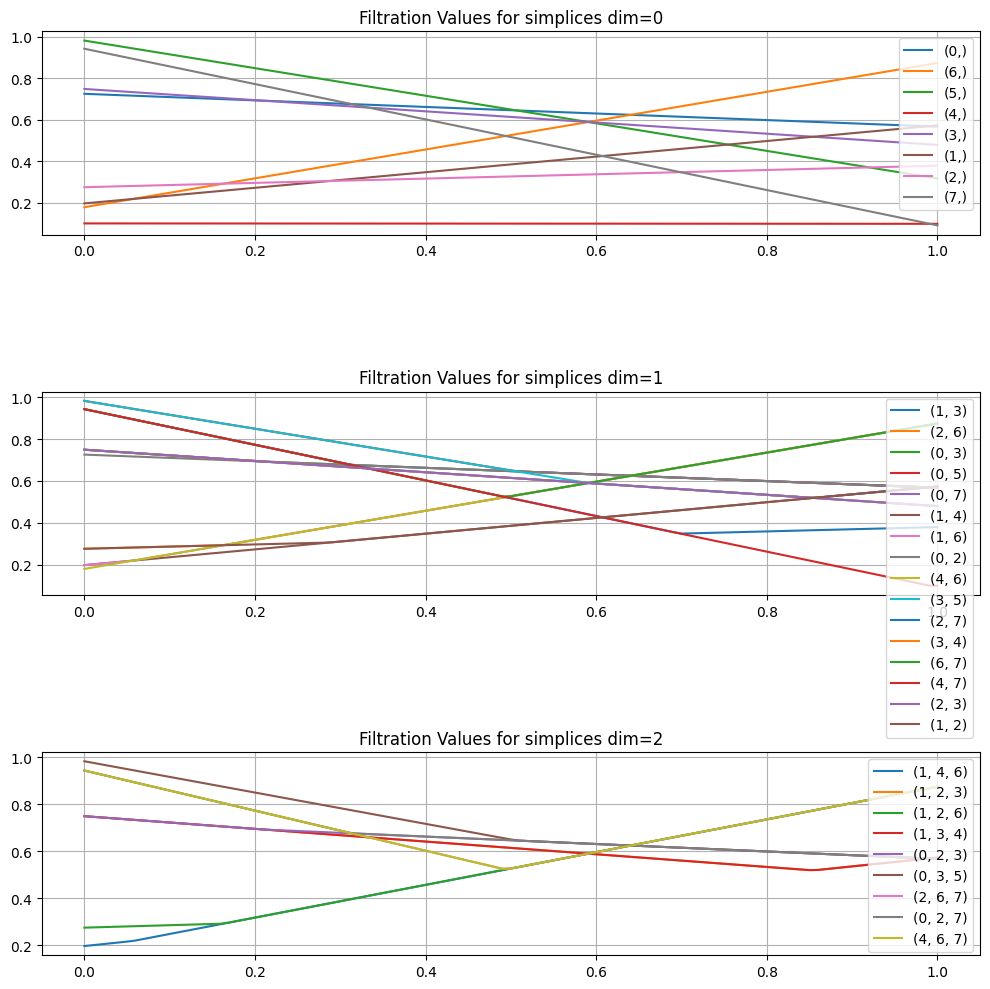

In [17]:
ts = np.linspace(0, 1, 101)
ys = []

for t in ts:
    heights = (1 - t)*heights0 + t*heights1
    stree = get_heights_stree(heights, triangles)
    ys.append({simplex: stree.filtration(simplex) for simplex in simplices})

ys = pd.DataFrame(ys, index=ts)

fig, axs = plt.subplots(3, figsize=(10, 10))
for dim in range(3):
    axs[dim].set_title(f'Filtration Values for simplices dim={dim}')
    ys[simplices[dims == dim]].plot(ax=axs[dim])
    axs[dim].grid(True)

plt.tight_layout()
plt.show()

## Studying 1 Transposition

In [18]:
cross_parameters = get_cross_parameters(heights0, heights1)

vertices0, vertices1 = np.argwhere(~np.isnan(cross_parameters)).transpose()
vertices0, vertices1 = vertices0[vertices1 > vertices0], vertices1[vertices1 > vertices0]
df_height_transpositions = pd.DataFrame(
    {
        'Vertex 0': vertices0, 
        'Vertex 1': vertices1, 
        'Time': cross_parameters[vertices0, vertices1]
    }
)
df_height_transpositions['Value'] = df_height_transpositions.apply(lambda row: ((1 - row['Time'])*heights0 + row['Time']*heights[1])[int(row['Vertex 0'])], axis=1)

eps = np.unique(np.concatenate([df_height_transpositions['Time'].values, [0, 1]]))
eps = 0.5*min(eps[1:] - eps[:-1])
print(f'eps = {eps:.1e}')


print(f'df_height_transpositions.shape = {df_height_transpositions.shape}')
df_height_transpositions.head()

eps = 3.9e-05
df_height_transpositions.shape = (19, 4)


/tmp/ipykernel_99818/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


,Vertex 0,Vertex 1,Time,Value
0,0,1,0.989215,0.574945
1,0,3,0.209837,0.693768
2,0,5,0.506727,0.648505
3,0,6,0.640503,0.628110
4,0,7,0.313398,0.677980


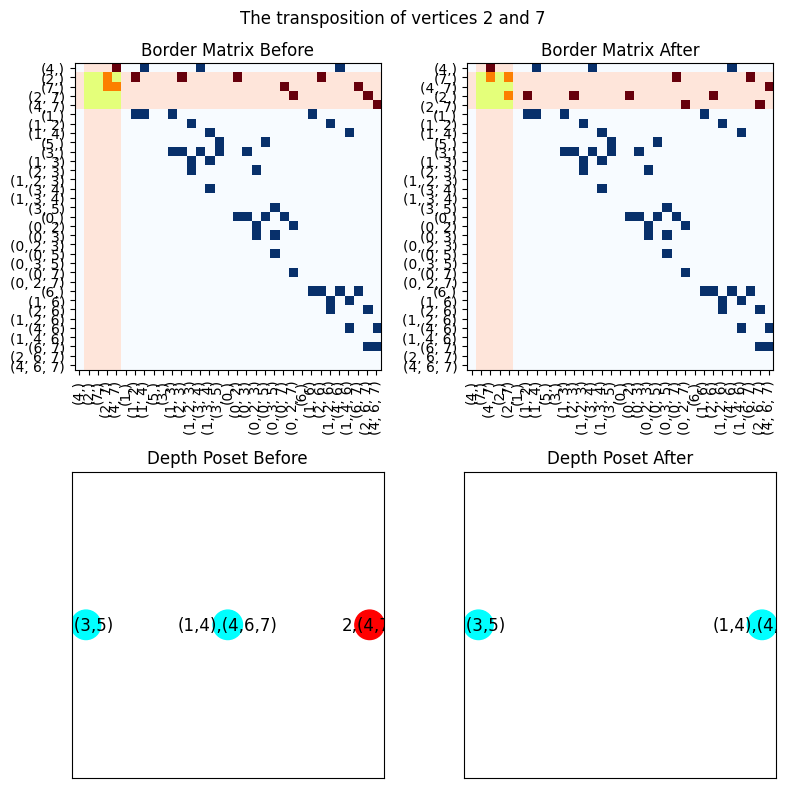

In [19]:
i = np.random.choice(df_height_transpositions.index)
time = df_height_transpositions.loc[i, 'Time']
vertex0, vertex1 = df_height_transpositions.loc[i, ['Vertex 0', 'Vertex 1']].astype(int)
simplex0, simplex1 = (vertex0, ), (vertex1, )


time_before = time - eps
heights_before = heights0*(1 - time_before) + heights1*time_before
stree_before = get_heights_stree(heights_before, triangles)
dp_before = DepthPoset.from_simplex_tree(stree_before)
order_before, matrix_before = depth.get_ordered_border_matrix_from_simplex_tree(stree_before)
order_before = np.array(order_before, dtype=object)

time_after = time + eps
heights_after = heights0*(1 - time_after) + heights1*time_after
stree_after = get_heights_stree(heights_after, triangles)
order_after, matrix_after = depth.get_ordered_border_matrix_from_simplex_tree(stree_after)
dp_after = DepthPoset.from_simplex_tree(stree_after)
order_after = np.array(order_after, dtype=object)

intersecting_node_sources = {node.source for node in dp_before.nodes} & {node.source for node in dp_after.nodes}
intersecting_edge_sources = {(e0.source, e1.source) for e0, e1 in dp_before.edges} & {(e0.source, e1.source) for e0, e1 in dp_after.edges}


fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle(f'The transposition of vertices {vertex0} and {vertex1}')

for i, (heightsi, titlei) in enumerate(zip([heights_before, heights_after], ['Before', 'After'])):
    streei = get_heights_stree(heightsi, triangles)
    dpi = DepthPoset.from_simplex_tree(streei)
    orderi, matrixi = depth.get_ordered_border_matrix_from_simplex_tree(streei)

    #axs[0, i].set_title(f'Complex {titlei}')
    #sm = axs[0, i].tripcolor(triang, heightsi, shading='gouraud', cmap=cmap, vmin=0, vmax=1)
    #axs[0, i].triplot(triang, color='black', linewidth=0.5)
    #enumerate_points(points, ax=axs[0, i], weight='semibold', forewidth=2)
    #plt.colorbar(sm, ax=axs[0, i])

    axs[0, i].set_title(f'Border Matrix {titlei}')
    axs[0, i].imshow(matrixi, cmap='Blues', vmin=0, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[order_before == order_after, :] = np.nan
    axs[0, i].imshow(matrixj, cmap='Reds', vmin=-0.1, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[:, order_before == order_after] = np.nan
    axs[0, i].imshow(matrixj, cmap='Reds', vmin=-0.1, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[order_before == order_after, :] = np.nan
    matrixj[:, order_before == order_after] = np.nan
    axs[0, i].imshow(matrixj, cmap='Wistia', vmin=0.0, vmax=1)


    axs[0, i].set_xticks(np.arange(len(orderi)), orderi, rotation=90)
    axs[0, i].set_yticks(np.arange(len(orderi)), orderi, rotation=0)

    axs[1, i].set_title(f'Depth Poset {titlei}')
    node_colors = ['cyan' if node.source in intersecting_node_sources else 'red' for node in dpi.nodes]
    edge_colors = ['navy' if (e0.source, e1.source) in intersecting_edge_sources else 'maroon' for e0, e1 in dpi.edges]

    nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.hasse_layout(), ax=axs[1, i], 
                     node_size=450, node_color=node_colors, edge_color=edge_colors, 
                     hide_ticks=True, with_labels=True)
    
plt.tight_layout()
plt.show()

In [20]:
def get_series_of_transpositions(simplex0, simplex1, order_before, order_after, direction_up=True) -> list:
    """
    """
    order_before = np.array(order_before, dtype=object)
    order_after = np.array(order_after, dtype=object)

    if len(order_before) != len(set(order_before)):
        raise ValueError(f'Some simplex is repeated in order_before.')
    if len(order_after) != len(set(order_after)):
        raise ValueError(f'Some simplex is repeated in order_after.')
    if set(order_before) != set(order_after):
        raise ValueError('The orders should contain similar simplices.')
    

    if list(order_before).index(simplex0) > list(order_before).index(simplex1):
        simplex0, simplex1 = simplex1, simplex0

    group0_before = np.array([len(set(simplex)&set(simplex0)) == len(simplex0) for simplex in order_before]) & (order_before != order_after)
    group1_before = np.array([len(set(simplex)&set(simplex1)) == len(simplex1) for simplex in order_before]) & (order_before != order_after)
    group2_before = group0_before & group1_before
    group0_before = group0_before & ~group2_before
    group1_before = group1_before & ~group2_before
    #print(f'0b: {order_before[group0_before]}')
    #print(f'1b: {order_before[group1_before]}')
    #print(f'2b: {order_before[group2_before]}')

    group0_after = np.array([len(set(simplex)&set(simplex0)) == len(simplex0) for simplex in order_after]) & (order_before != order_after)
    group1_after = np.array([len(set(simplex)&set(simplex1)) == len(simplex1) for simplex in order_after]) & (order_before != order_after)
    group2_after = group0_after & group1_after
    group0_after = group0_after & ~group2_after
    group1_after = group1_after & ~group2_after
    #print(f'0a: {order_after[group0_after]}')
    #print(f'1a: {order_after[group1_after]}')
    #print(f'2a: {order_after[group2_after]}')

    group0_before_index = np.where(group0_before)[0]
    group1_before_index = np.where(group1_before)[0]
    group2_before_index = np.where(group2_before)[0]
    #print(f'0b: {group0_before_index}')
    #print(f'1b: {group1_before_index}')
    #print(f'2b: {group2_before_index}')

    group0_after_index = np.where(group0_after)[0]
    group1_after_index = np.where(group1_after)[0]
    group2_after_index = np.where(group2_after)[0]
    #print(f'0a: {group0_after_index}')
    #print(f'1a: {group1_after_index}')
    #print(f'2a: {group2_after_index}')

    if not np.all([(group0_before_index >= list(order_before).index(simplex0)).all(), 
                   (group1_before_index >= list(order_before).index(simplex1)).all(), 
                   (group2_before_index > list(order_before).index(simplex0)).all(), 
                   (group2_before_index > list(order_before).index(simplex1)).all()]):
        raise ValueError('There are cofaces before their faces in the order_before')

    if not np.all([(group0_after_index >= list(order_after).index(simplex0)).all(), 
                   (group1_after_index >= list(order_after).index(simplex1)).all(), 
                   (group2_after_index > list(order_after).index(simplex0)).all(),
                   (group2_after_index > list(order_after).index(simplex1)).all()]):
        raise ValueError('There are cofaces before their faces in the order_after')
    
    assert len(group0_before_index) == len(group0_after_index)
    assert len(group1_before_index) == len(group1_after_index)
    assert len(group2_before_index) == len(group2_after_index)

    if direction_up:
        # sort group 1
        group1_before_index = np.sort(group1_before_index)
        group1_after_index = np.sort(group1_after_index)

        # move up group 1
        transpositions1 = [np.arange(i_before, i_after, -1) for i_before, i_after in zip(group1_before_index, group1_after_index)]
        if len(transpositions1) > 0:
            transpositions1 = np.concatenate(transpositions1)
            transpositions1 = np.transpose([transpositions1 - 1, transpositions1])
        else:
            transpositions1 = np.zeros([0, 2], dtype=int)

        # find a result middle order
        order_midle = order_before.copy()
        for i, j in transpositions1:
            order_midle[i], order_midle[j] = order_midle[j], order_midle[i] 

        # find indices of group 2 in the middle order
        group0_midle = np.array([len(set(simplex)&set(simplex0)) == len(simplex0) for simplex in order_midle]) & (order_midle != order_after)
        group1_midle = np.array([len(set(simplex)&set(simplex1)) == len(simplex1) for simplex in order_midle]) & (order_midle != order_after)
        group2_midle = group0_midle & group1_midle
        group2_midle_index = np.where(group2_midle)[0]
        group2_midle_index = np.sort(group2_midle_index)
        
        # move up group 2
        transpositions2 = [np.arange(i_before, i_after, -1) for i_before, i_after in zip(group2_midle_index, group2_after_index)]
        if len(transpositions2) > 0:
            transpositions2 = np.concatenate(transpositions2)
            transpositions2 = np.transpose([transpositions2 - 1, transpositions2])
        else:
            transpositions2 = np.zeros([0, 2], dtype=int)

        # concatenate transpositions
        transpositions = np.concatenate([transpositions1, transpositions2])
    else:
        # sort groups 0, 2
        group0_after_index = np.sort(group0_after_index)[::-1]
        group2_before_index = np.sort(group2_before_index)[::-1]
        group2_after_index = np.sort(group2_after_index)[::-1]
        group2_middle_index = np.sort(np.concatenate([group0_after_index, group1_after_index, group2_after_index]))[::-1][:len(group2_after_index)]
        

        # move down group 2
        transpositions2 = [np.arange(i_before, i_after, +1) for i_before, i_after in zip(group2_before_index, group2_middle_index)]
        if len(transpositions2) != 0:
            transpositions2 = np.concatenate(transpositions2)
            transpositions2 = np.transpose([transpositions2 + 1, transpositions2])
        else:
            transpositions2 = np.zeros([0, 2], dtype=int)

        # find a result middle order
        order_midle = order_before.copy()
        for i, j in transpositions2:
            order_midle[i], order_midle[j] = order_midle[j], order_midle[i] 

        # find indices of group 0 in the middle order
        group0_midle = np.array([len(set(simplex)&set(simplex0)) == len(simplex0) for simplex in order_midle]) & (order_midle != order_after)
        group1_midle = np.array([len(set(simplex)&set(simplex1)) == len(simplex1) for simplex in order_midle]) & (order_midle != order_after)
        group2_midle = group0_midle & group1_midle
        group0_midle = group0_midle & ~group2_midle
        group0_midle_index = np.where(group0_midle)[0]
        group0_midle_index = np.sort(group0_midle_index)[::-1]

        # move down group 0
        transpositions0 = [np.arange(i_before, i_after, +1) for i_before, i_after in zip(group0_midle_index, group0_after_index)]
        if len(transpositions0) != 0:
            transpositions0 = np.concatenate(transpositions0)
            transpositions0 = np.transpose([transpositions0 + 1, transpositions0])
        else:
            transpositions0 = np.zeros([0, 2], dtype=int)

        # concatenate transpositions
        transpositions = np.concatenate([transpositions2, transpositions0])

    return transpositions

In [21]:
df_transposition_orders = []

transpositions_up = get_series_of_transpositions(simplex0, simplex1, order_before, order_after, direction_up=True)
transpositions_dn = get_series_of_transpositions(simplex0, simplex1, order_before, order_after, direction_up=False)

for i_series, transposition_series in enumerate([transpositions_up, transpositions_dn]):
    df_transposition_orders.append(
        {
            'order': tuple(order_before), 
            'pos': (-1, i_series)
        }
    )
    current_order = order_before.copy()
    for i_index, (index0, index1) in enumerate(transposition_series):
        s0, s1 = current_order[index0], current_order[index1]

        current_order[index0], current_order[index1] = current_order[index1], current_order[index0] 
        df_transposition_orders.append(
            {
                'order': tuple(current_order), 
                'previous order': df_transposition_orders[-1]['order'], 
                'Index 0': index0, 
                'Index 1': index1,
                'Simplex 0': s0, 
                'Simplex 1': s1, 
                'pos': (i_index, i_series), 
            }
        )

df_transposition_orders = pd.DataFrame(df_transposition_orders)


def get_stree(row):
    # 
    stree = gh.SimplexTree()
    for value, simplex in enumerate(row['order']):
        stree.insert(simplex, value)
    return stree


df_transposition_orders['stree'] = df_transposition_orders.apply(get_stree, axis=1)
df_transposition_orders['dp'] = df_transposition_orders.apply(lambda row: DepthPoset.from_simplex_tree(row['stree']), axis=1)

dp_types = []
for dp in df_transposition_orders['dp']:
    if not (dp in dp_types):
        dp_types.append(dp)
df_transposition_orders['dp_id'] = df_transposition_orders.apply(lambda row: dp_types.index(row['dp']), axis=1)


print(f'df_transposition_orders.shape = {df_transposition_orders.shape}')
df_transposition_orders.head()


df_transposition_orders.shape = (8, 10)


,order,pos,previous order,Index 0,Index 1,Simplex 0,Simplex 1,stree,dp,dp_id
0,"((4,), (2,), (7,), (2, 7), (4, 7), (1,), (1, 2...","(-1, 0)",NaN,NaN,NaN,NaN,NaN,<gudhi.simplex_tree.SimplexTree object at 0x78...,<src.depth.DepthPoset object at 0x789a42e905f0>,0
1,"((4,), (7,), (2,), (2, 7), (4, 7), (1,), (1, 2...","(0, 0)","((4,), (2,), (7,), (2, 7), (4, 7), (1,), (1, 2...",1.0,2.0,"(2,)","(7,)",<gudhi.simplex_tree.SimplexTree object at 0x78...,<src.depth.DepthPoset object at 0x789a42e11b80>,1
2,"((4,), (7,), (2,), (4, 7), (2, 7), (1,), (1, 2...","(1, 0)","((4,), (7,), (2,), (2, 7), (4, 7), (1,), (1, 2...",3.0,4.0,"(2, 7)","(4, 7)",<gudhi.simplex_tree.SimplexTree object at 0x78...,<src.depth.DepthPoset object at 0x789a42eaa690>,2
3,"((4,), (7,), (4, 7), (2,), (2, 7), (1,), (1, 2...","(2, 0)","((4,), (7,), (2,), (4, 7), (2, 7), (1,), (1, 2...",2.0,3.0,"(2,)","(4, 7)",<gudhi.simplex_tree.SimplexTree object at 0x78...,<src.depth.DepthPoset object at 0x789a42eaad20>,2
4,"((4,), (2,), (7,), (2, 7), (4, 7), (1,), (1, 2...","(-1, 1)",NaN,NaN,NaN,NaN,NaN,<gudhi.simplex_tree.SimplexTree object at 0x78...,<src.depth.DepthPoset object at 0x789a42ea9fa0>,0


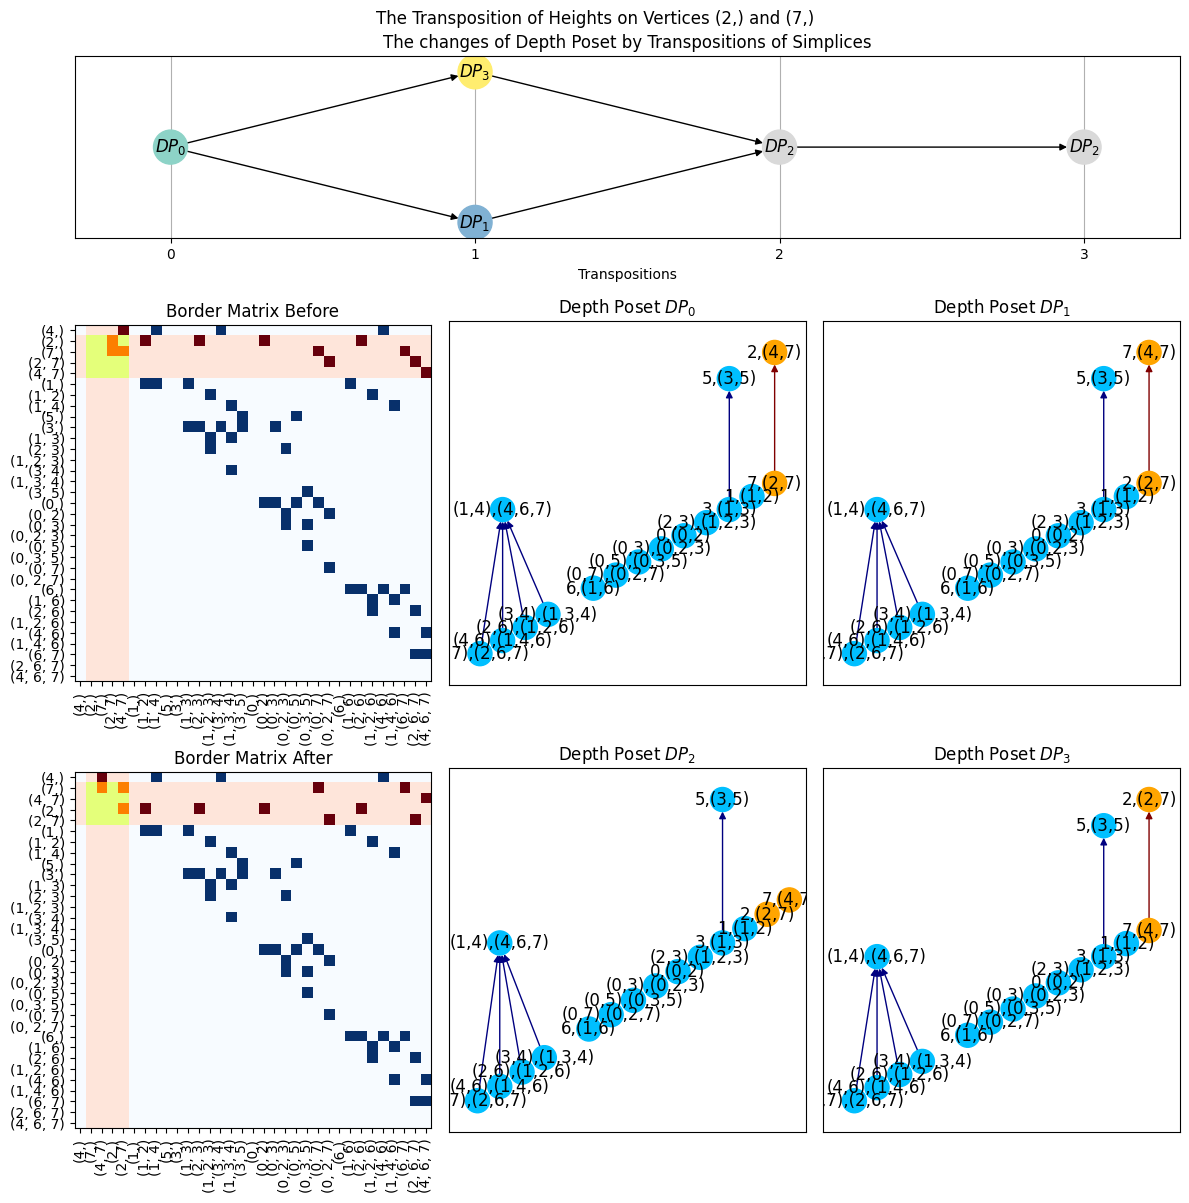

In [22]:
fig = plt.figure(figsize=(3 * len(dp_types), 12))
fig.suptitle(f'The Transposition of Heights on Vertices {simplex0} and {simplex1}')

k = np.ceil(len(dp_types)/2).astype(int)
gs = gridspec.GridSpec(3, k + 1, height_ratios=[1, 2, 2])

ax_top = fig.add_subplot(gs[0, :])
#ax_bottom = [fig.add_subplot(gs[1 + i%2, i//2]) for i in range(len(dp_types) + 2)]
ax_bottom = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[2, 0])] + [fig.add_subplot(gs[1 + i//k, i%k + 1]) for i in range(len(dp_types))]

# Changes
g_transposition_orders = nx.DiGraph()
g_transposition_orders.add_nodes_from(set(df_transposition_orders['order']))
g_transposition_orders.add_edges_from(df_transposition_orders[~df_transposition_orders['previous order'].isna()][['previous order', 'order']].values)

pos = dict(df_transposition_orders.groupby('order')['pos'].apply(lambda col: np.array(list(col)).mean(axis=0)))
node_dp_index = {node: df_transposition_orders[df_transposition_orders['order'] == node]['dp_id'].iloc[0] for node in g_transposition_orders.nodes}
node_labels = {node: f'$DP_{{{node_dp_index[node]}}}$' for node in g_transposition_orders.nodes}
node_colors = [plt.get_cmap('Set3')(node_dp_index[node]/max(node_dp_index.values())) for node in g_transposition_orders.nodes]

ax_top.set_title(f'The changes of Depth Poset by Transpositions of Simplices')
nx.draw_networkx(g_transposition_orders, pos=pos, node_size=600, node_color=node_colors, labels=node_labels, 
                 ax=ax_top, hide_ticks=False)
ax_top.set_yticks([])
maxpos = np.array(list(pos.values()))[:, 0].max()
ax_top.set_xticks(np.arange(-1, maxpos + 1), 
                  np.arange(0, maxpos + 2).astype(int))
ax_top.set_xlabel('Transpositions')
ax_top.grid(True)


# Depth Posets
general_nodes = set(dp_types[0].nodes)
general_edges = set(dp_types[0].get_transitive_closure().edges)
for dp in dp_types:
    general_nodes = general_nodes & set(dp.nodes)
    general_edges = general_edges & set(dp.get_transitive_closure().edges)

for idp, dp in enumerate(dp_types):
    ax_bottom[idp + 2].set_title(f'Depth Poset $DP_{{{idp}}}$')

    node_colors = ['deepskyblue' if node in general_nodes else 'orange' for node in dp.nodes]
    edge_colors = ['navy' if edge in general_edges else 'maroon' for edge in dp.get_transitive_reduction().edges]

    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.hasse_layout(alignment_slope=0.1),
                     node_color=node_colors, edge_color=edge_colors, with_labels=True,
                     ax=ax_bottom[idp + 2])

# Border Matrices
for i, (heightsi, titlei) in enumerate(zip([heights_before, heights_after], ['Before', 'After'])):
    streei = get_heights_stree(heightsi, triangles)
    dpi = DepthPoset.from_simplex_tree(streei)
    orderi, matrixi = depth.get_ordered_border_matrix_from_simplex_tree(streei)

    ax_bottom[i].set_title(f'Border Matrix {titlei}')
    ax_bottom[i].imshow(matrixi, cmap='Blues', vmin=0, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[order_before == order_after, :] = np.nan
    ax_bottom[i].imshow(matrixj, cmap='Reds', vmin=-0.1, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[:, order_before == order_after] = np.nan
    ax_bottom[i].imshow(matrixj, cmap='Reds', vmin=-0.1, vmax=1)
    matrixj = matrixi.astype(float)
    matrixj[order_before == order_after, :] = np.nan
    matrixj[:, order_before == order_after] = np.nan
    ax_bottom[i].imshow(matrixj, cmap='Wistia', vmin=0.0, vmax=1)


    ax_bottom[i].set_xticks(np.arange(len(orderi)), orderi, rotation=90)
    ax_bottom[i].set_yticks(np.arange(len(orderi)), orderi, rotation=0)


plt.tight_layout()
plt.show()

## 

## Orders During Linear Homotopy of Heights